### Exercise 2b)

In [16]:
from utils.neural_network import NeuralNetwork
import numpy as np
import matplotlib.pyplot as plt
from utils.training import GradientDescent, StochasticGradientDescent
from utils.step_methods import ConstantLearningRateStep, MomentumStep, ADAgradStep, RMSpropStep, AdamStep

In [17]:
from utils.cost_functions import SoftmaxCrossEntropy,MSE
from utils.activation_functions import Sigmoid, Identity
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [37]:
def runge(x): 
    return 1/(1 + 25*x**2)

np.random.seed(124)

n = 500
x = np.random.uniform(-1, 1, n)
y = runge(x) + 0.05*np.random.normal(0, 1, n)
x = x.reshape(-1,1)
y = y.reshape(-1,1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state = 44)

n_folds = 5

model = LinearRegression(fit_intercept=True)

model = make_pipeline(PolynomialFeatures(degree=12, include_bias=True), StandardScaler(), model)

kfold = KFold(n_splits=n_folds,shuffle=True,random_state=44)
estimated_mse_folds = cross_val_score(model, x, y, scoring='neg_mean_squared_error', cv=kfold)
mse_OLS = np.mean(-estimated_mse_folds)

print("Testing MSE for OLS linear regression: ",mse_OLS)

network_input_size = 1
network_output_size = 1

layer_output_sizes = [50, 50, network_output_size]
activation_funcs = [Sigmoid(), Sigmoid(), Identity()]

no_train_mse = np.zeros(n_folds)
train_mse = np.zeros(n_folds)

for fold_idx,(train_idx, test_idx) in enumerate(kfold.split(x)): 
    net = NeuralNetwork(network_input_size,
        layer_output_sizes,
        activation_funcs,
        MSE(),
    )
    x_train = x[train_idx]
    x_test = x[test_idx]
    y_train = y[train_idx]
    y_test = y[test_idx]
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    no_train_mse[fold_idx] = net.cost_batch(x_test,y_test)
    net.train(StochasticGradientDescent(step_method=RMSpropStep(learning_rate=0.01, decay_rate=0.9),inputs = x_train, targets = y_train),2000)
    train_mse[fold_idx] = net.cost_batch(x_test,y_test)

print("Testing MSE for neural network before training: ",np.mean(no_train_mse))

print("Testing MSE for neural network after training: ",np.mean(train_mse))


Testing MSE for OLS linear regression:  0.0033842036002902426
Testing MSE for neural network before training:  17.125311352366346
Testing MSE for neural network after training:  0.002987856039181195


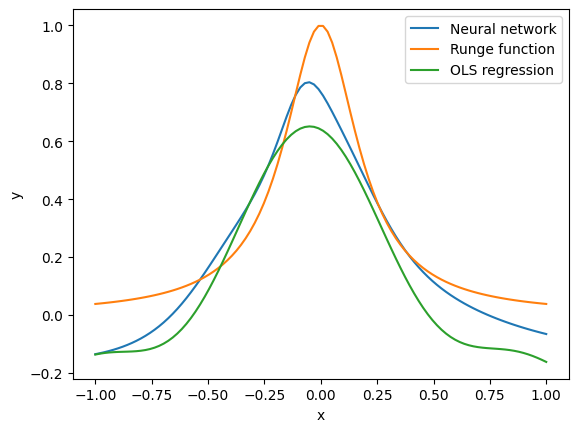

In [32]:
x_test = np.linspace(-1,1, 100)
y_pred = net.predict(x_test.reshape(-1, 1))

model = LinearRegression(fit_intercept=False)

model = make_pipeline(PolynomialFeatures(degree=12, include_bias=False), StandardScaler(), model)

plt.plot(x_test,y_pred,label="Neural network")
plt.plot(x_test,runge(x_test),label="Runge function")
plt.plot(x_test,model.fit(x_train.reshape(-1,1), y_train).predict(x_test.reshape(-1,1)),label="OLS regression")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

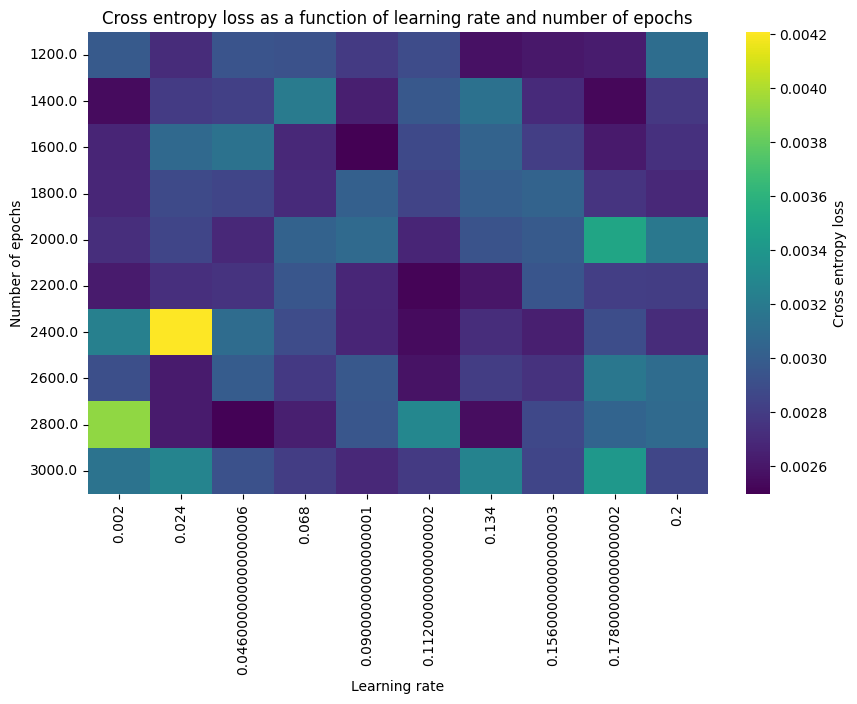

In [ ]:
import seaborn as sns

learning_rates = np.linspace(0.002,0.2,10)
epochs = np.linspace(1200,3000,10)

loss = np.zeros((len(epochs),len(learning_rates)))

for i in range(len(learning_rates)):
    for j in range(len(epochs)):
        for fold_idx,(train_idx, test_idx) in enumerate(kfold.split(x)): 
            net = NeuralNetwork(network_input_size,
                layer_output_sizes,
                activation_funcs,
                MSE(),
            )
            x_train = x[train_idx]
            x_test = x[test_idx]
            y_train = y[train_idx]
            y_test = y[test_idx]
            scaler = StandardScaler()
            x_train = scaler.fit_transform(x_train)
            x_test = scaler.transform(x_test)
            net.train(StochasticGradientDescent(step_method=RMSpropStep(learning_rate=0.01, decay_rate=0.9),inputs = x_train, targets = y_train),2000)
            loss[j,i] = net.cost_batch(x_test,y_test)

In [ ]:
# display a heatmap, where the color represnts the value of the accuracy
plt.figure(figsize=(10, 6))
sns.heatmap(
    loss,  
    fmt=".2f",   
    cmap="viridis", 
    xticklabels=learning_rates,
    yticklabels=epochs,cbar_kws={"label": "Cross entropy loss"}
)

plt.xlabel("Learning rate")
plt.ylabel("Number of epochs")
plt.title("Cross entropy loss as a function of learning rate and number of epochs")
plt.show()